In [5]:
!pip install pennylane
import numpy as np
import pandas as pd
import random, os, time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import torch
import torch.nn as nn

import pennylane as qml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 97.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [6]:
torch.set_default_dtype(torch.float32)


In [7]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)


In [8]:
df = pd.read_excel("LA-ICP-MS Data (1).xlsx", sheet_name="Sheet0", header=1)

coords = df[['x', 'y']]
chem = df.drop(columns=['Sample ID', 'x', 'y'])
chem = chem.select_dtypes(np.number)
chem = chem.fillna(chem.mean())


In [9]:
def clr_transform(X):
    X = np.clip(X, 1e-9, None)
    logX = np.log(X)
    gm = logX.mean(axis=1, keepdims=True)
    return logX - gm

clr_data = clr_transform(chem.values)


In [10]:
scaler = StandardScaler()
clr_scaled = scaler.fit_transform(clr_data)


In [11]:
pca = PCA(n_components=4, random_state=42)
X_pca = pca.fit_transform(clr_scaled)

print("Explained variance:", pca.explained_variance_ratio_.sum())


Explained variance: 0.7590152998989446


In [12]:
SUBSET_SIZE = 2000   # guarantees <5 min
idx = np.random.choice(len(X_pca), SUBSET_SIZE, replace=False)

X_train_qnn = torch.tensor(X_pca[idx], dtype=torch.float32)


In [13]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, interface="torch")
def quantum_layer(x, weights):
    for i in range(4):
        qml.RY(x[i], wires=i)

    for i in range(3):
        qml.CZ(wires=[i, i+1])
    qml.CZ(wires=[3, 0])

    for i in range(4):
        qml.RY(weights[i], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(4)]


In [14]:
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 4)
        self.q_weights = nn.Parameter(torch.randn(4))
        self.fc2 = nn.Linear(4, 4)

    def forward(self, x):
        print(f"Input x dtype: {x.dtype}")
        x = torch.tanh(self.fc1(x))
        print(f"After fc1 and tanh dtype: {x.dtype}")

        q_out = []
        for i, xi in enumerate(x):
            q_vals_from_qnode = quantum_layer(xi, self.q_weights)
            # PennyLane expval often returns float64. Explicitly cast immediately.
            q_vals_float = torch.tensor(q_vals_from_qnode, dtype=torch.float32)
            # print(f"Qnode output (tensor) dtype for element {i}: {q_vals_float.dtype}") # Optional: too verbose
            q_out.append(q_vals_float)

        final_q_out = torch.stack(q_out)
        print(f"Final q_out dtype before fc2: {final_q_out.dtype}")
        return self.fc2(final_q_out)

In [15]:
model = HybridQNN().float()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 10   # intentionally small

start = time.time()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    out = model(X_train_qnn)
    loss = torch.mean(out ** 2)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

print(f"Training time: {(time.time() - start)/60:.2f} minutes")

Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32


/tmp/ipython-input-3441669158.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  q_vals_float = torch.tensor(q_vals_from_qnode, dtype=torch.float32)


Final q_out dtype before fc2: torch.float32
Epoch 1/10, Loss: 0.1468
Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torch.float32
Epoch 2/10, Loss: 0.1329
Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torch.float32
Epoch 3/10, Loss: 0.1200
Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torch.float32
Epoch 4/10, Loss: 0.1083
Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torch.float32
Epoch 5/10, Loss: 0.0977
Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torch.float32
Epoch 6/10, Loss: 0.0882
Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torch.float32
Epoch 7/10, Loss: 0.0797
Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torc

In [16]:
for p in model.parameters():
    p.requires_grad = False


In [17]:
X_full = torch.tensor(X_pca, dtype=torch.float32)

with torch.no_grad():
    quantum_embeddings = model(X_full).numpy()


Input x dtype: torch.float32
After fc1 and tanh dtype: torch.float32
Final q_out dtype before fc2: torch.float32


In [19]:
labels_qnn = KMeans(n_clusters=4, random_state=42).fit_predict(quantum_embeddings)
print("HQCNN silhouette:", silhouette_score(quantum_embeddings, labels_qnn))


HQCNN silhouette: 0.4168264


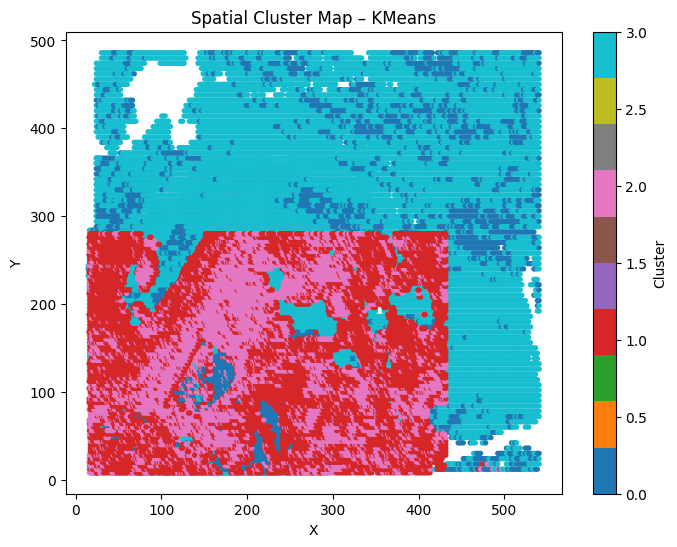

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(coords['x'], coords['y'], c=labels_kmeans, cmap='tab10', s=8)
plt.title("Spatial Cluster Map – KMeans")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Cluster")
plt.show()


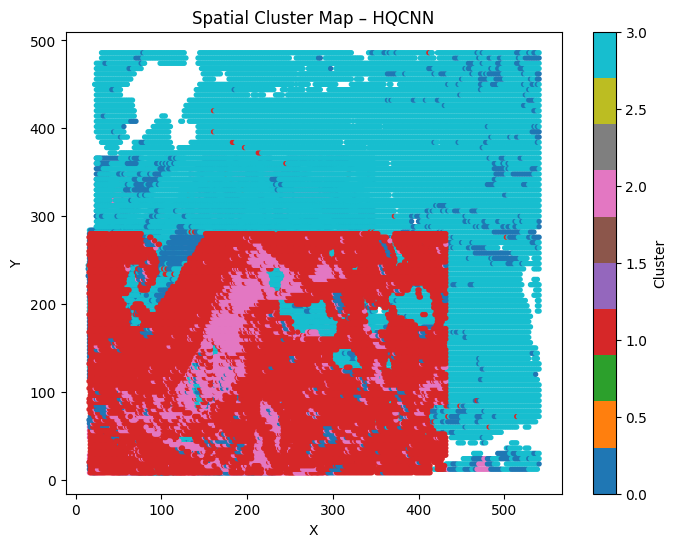

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(coords['x'], coords['y'], c=labels_qnn, cmap='tab10', s=8)
plt.title("Spatial Cluster Map – HQCNN")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Cluster")
plt.show()


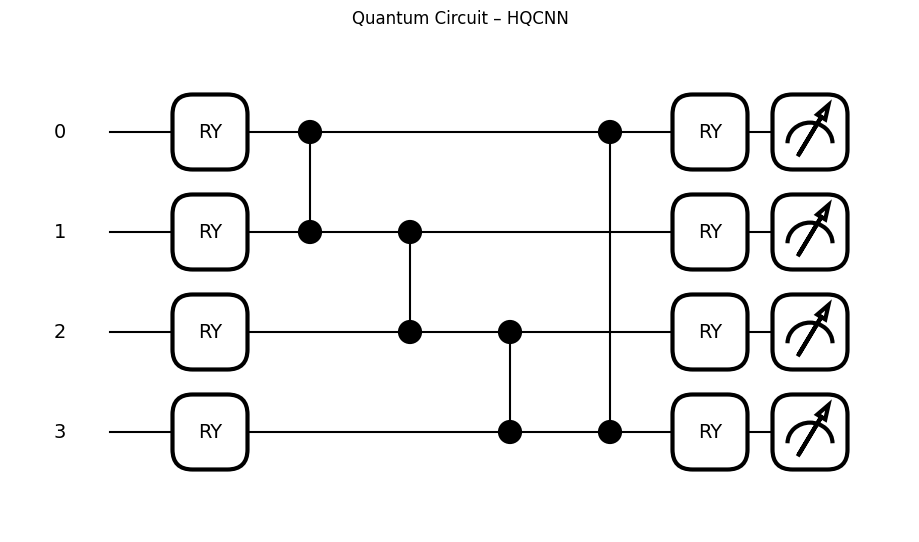

In [51]:
fig, ax = draw_mpl(quantum_layer)(X_tensor[0], model.q_weights)
plt.title("Quantum Circuit – HQCNN")
plt.show()


In [52]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_kmeans = kmeans.fit_predict(X_pca)

print("KMeans Silhouette:", silhouette_score(X_pca, labels_kmeans))
print("HQCNN Silhouette:", silhouette_score(quantum_embeddings, labels_qnn))


KMeans Silhouette: 0.29546454125321786
HQCNN Silhouette: 0.43590385


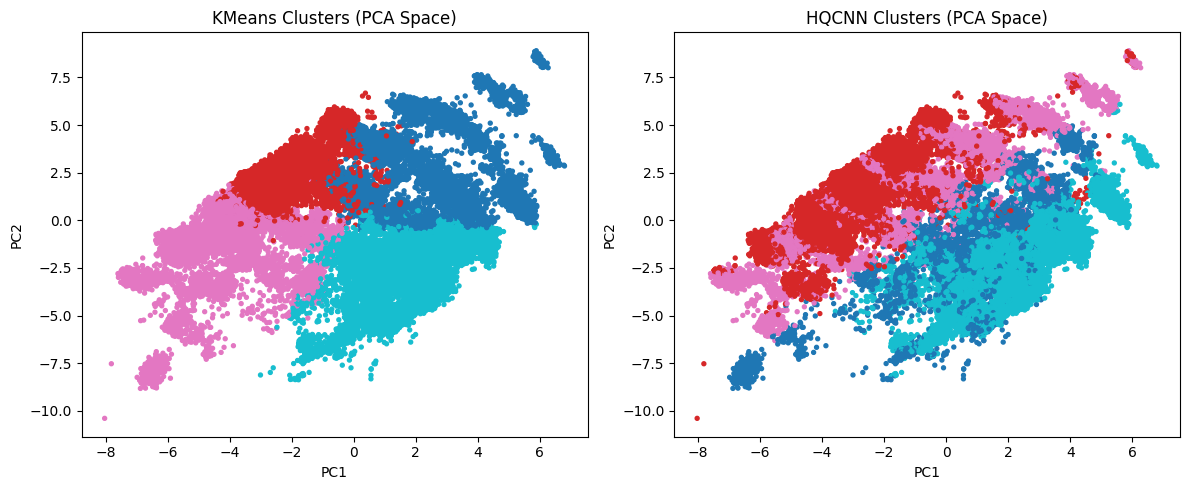

In [53]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', s=8)
plt.title("KMeans Clusters (PCA Space)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_qnn, cmap='tab10', s=8)
plt.title("HQCNN Clusters (PCA Space)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


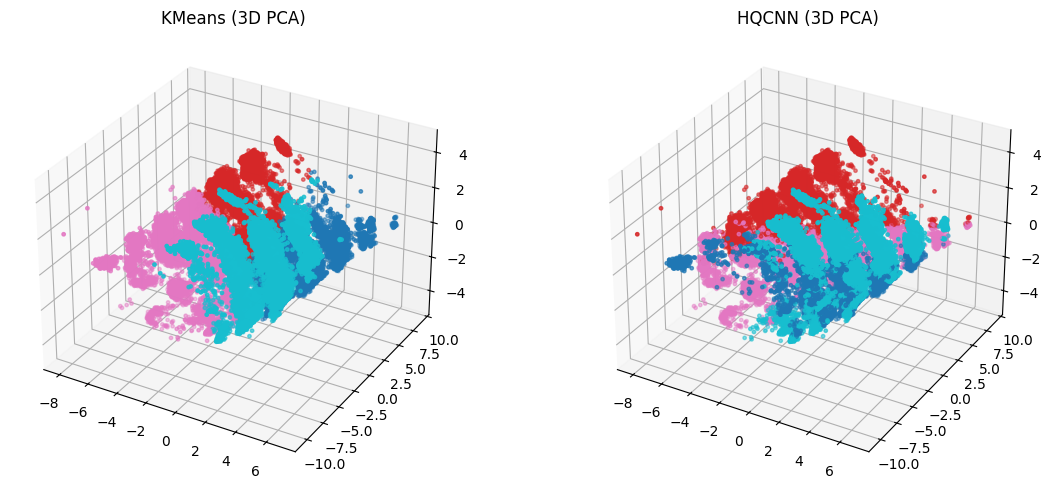

In [54]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels_kmeans, cmap='tab10', s=6)
ax1.set_title("KMeans (3D PCA)")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels_qnn, cmap='tab10', s=6)
ax2.set_title("HQCNN (3D PCA)")

plt.tight_layout()
plt.show()


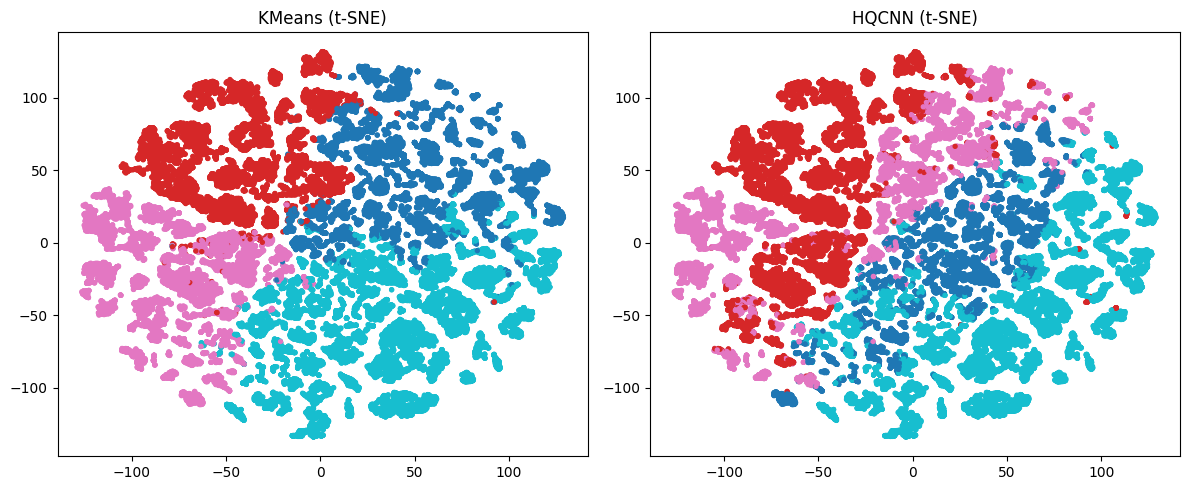

In [55]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_kmeans, cmap='tab10', s=8)
plt.title("KMeans (t-SNE)")

plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_qnn, cmap='tab10', s=8)
plt.title("HQCNN (t-SNE)")

plt.tight_layout()
plt.show()


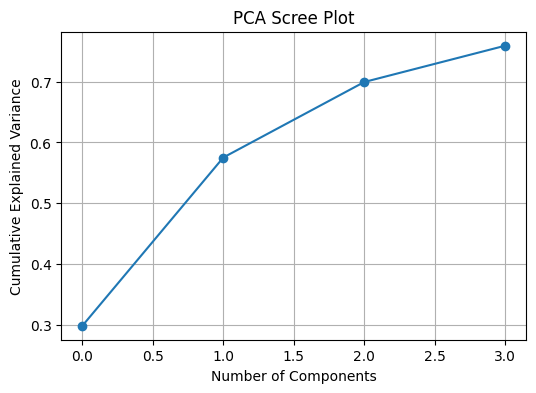

In [56]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()


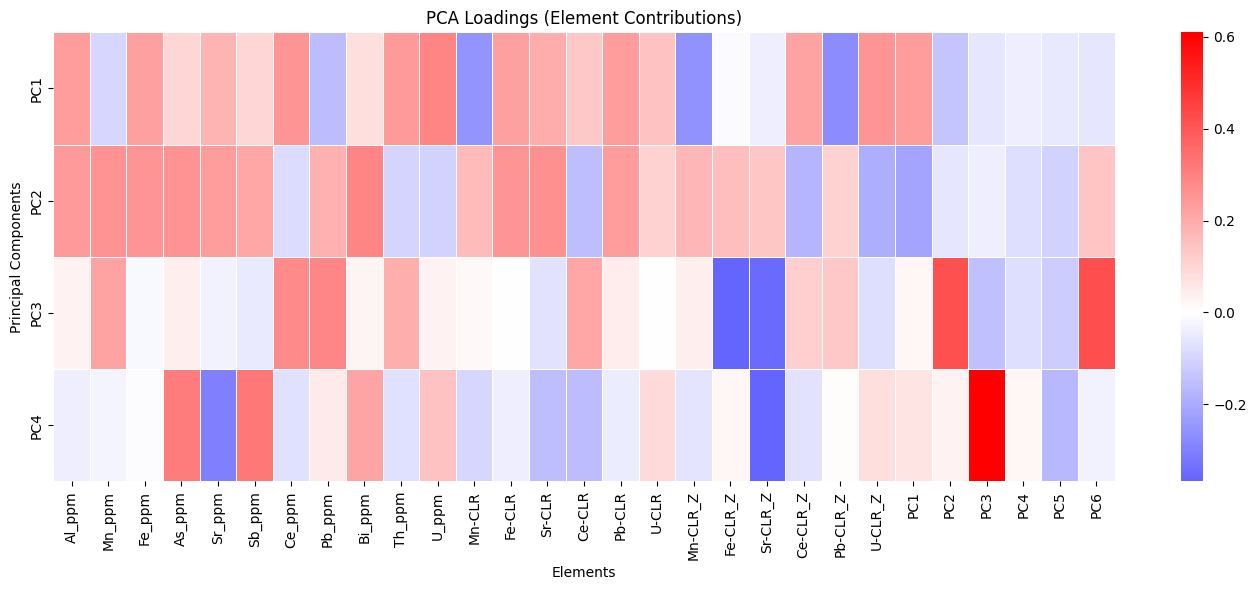

In [57]:
pca_loadings = pd.DataFrame(
    pca.components_,
    columns=chem.columns,
    index=['PC1','PC2','PC3','PC4']
)

plt.figure(figsize=(14,6))
sns.heatmap(pca_loadings, cmap='bwr', center=0, linewidths=0.5)
plt.title("PCA Loadings (Element Contributions)")
plt.xlabel("Elements")
plt.ylabel("Principal Components")
plt.tight_layout()
plt.show()


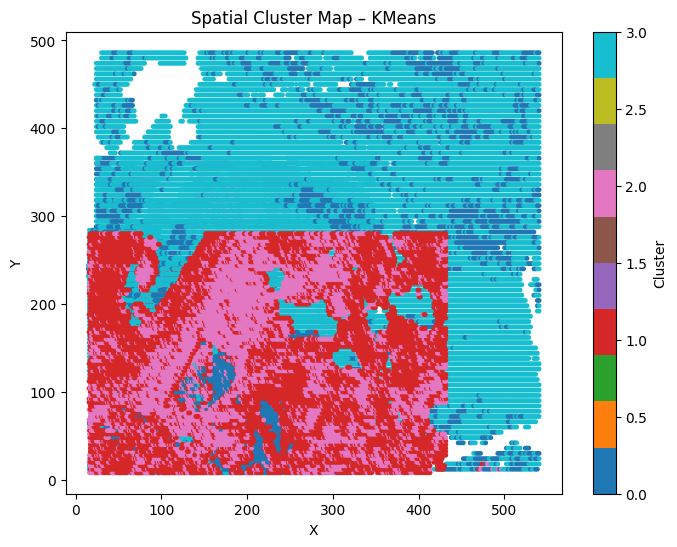

In [58]:
plt.figure(figsize=(8,6))
plt.scatter(coords['x'], coords['y'], c=labels_kmeans, cmap='tab10', s=6)
plt.title("Spatial Cluster Map – KMeans")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Cluster")
plt.show()


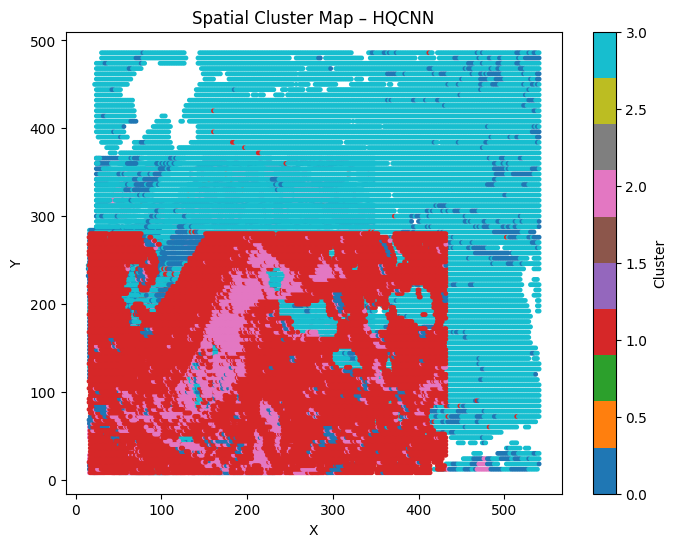

In [59]:
plt.figure(figsize=(8,6))
plt.scatter(coords['x'], coords['y'], c=labels_qnn, cmap='tab10', s=6)
plt.title("Spatial Cluster Map – HQCNN")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Cluster")
plt.show()


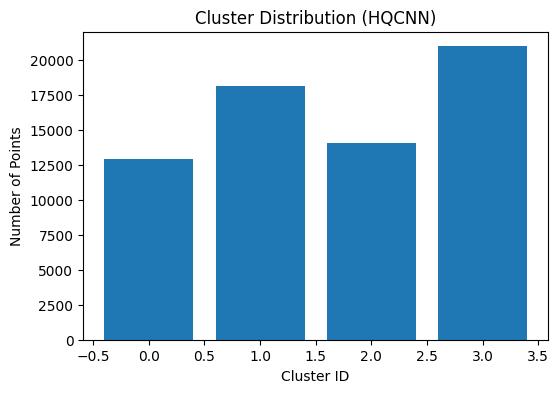

In [60]:
import matplotlib.pyplot as plt
import numpy as np

clusters, counts = np.unique(labels_qnn, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(clusters, counts)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Points")
plt.title("Cluster Distribution (HQCNN)")
plt.show()


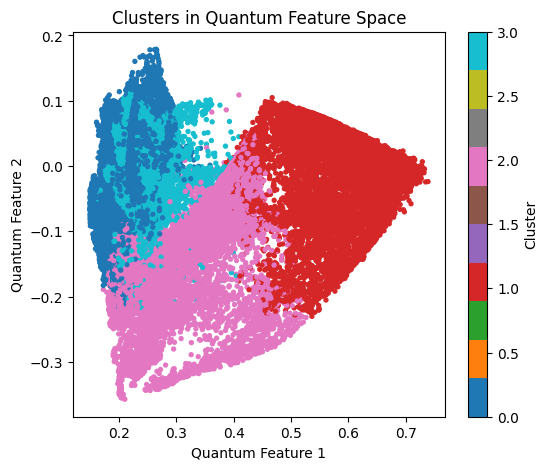

In [61]:
plt.figure(figsize=(6,5))
plt.scatter(
    quantum_embeddings[:, 0],
    quantum_embeddings[:, 1],
    c=labels_qnn,
    cmap="tab10",
    s=8
)
plt.xlabel("Quantum Feature 1")
plt.ylabel("Quantum Feature 2")
plt.title("Clusters in Quantum Feature Space")
plt.colorbar(label="Cluster")
plt.show()


In [20]:
import pandas as pd

pc_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2", "PC3", "PC4"]
)

pc_df["Cluster"] = labels_qnn

cluster_pc_means = pc_df.groupby("Cluster").mean()
print(cluster_pc_means)


              PC1       PC2       PC3       PC4
Cluster                                        
0       -0.428854  1.579283  0.326920 -0.241311
1        2.236103 -2.602429  0.870301 -0.575352
2       -2.232434  0.640573 -1.023461  0.463231
3        2.590029 -1.396243  0.626743 -0.059867
